In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
# Zonals stats packages
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

## Import the CHM into python

In [2]:
# Import Lidar CHM
sjer_data_path = os.path.join("data", "spatial-vector-lidar", "california", 
                             "neon-sjer-site")
sjer_chm_path = os.path.join(sjer_data_path, "2013", "lidar", "SJER_lidarCHM.tif")


sjer_chm_path

'data/spatial-vector-lidar/california/neon-sjer-site/2013/lidar/SJER_lidarCHM.tif'

In [3]:
with rio.open(sjer_chm_path) as sjer_lidar_chm_src:
    # Read in the data, 1 specifies only import the first layer of the raster!
    sjer_lidar_chm = sjer_lidar_chm_src.read(1, masked=True)
    # Grab the metadata
    sjer_lidar_chm_meta = sjer_lidar_chm_src.meta
    # you don't need this for your homework but IF you want to plot the data you will!
    sjer_plot_extent = plotting_extent(sjer_lidar_chm_src)

    
sjer_lidar_chm.shape
sjer_lidar_chm_src.meta
sjer_plot_extent

(254571.0, 258867.0, 4107303.0, 4112362.0)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12214e550>)

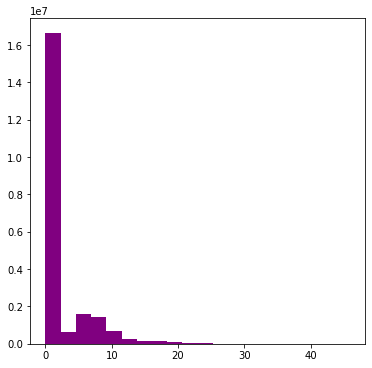

In [4]:
# View a histogram of the data

ep.hist(sjer_lidar_chm,
       figsize=(6,6))

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14889ef90>)

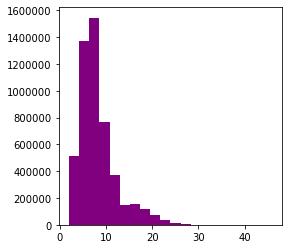

In [7]:
# Assign all array or chm values of 0 --> None or numpy.nan 
# this will ensure the pixel values of 0 are NOT included in our calculation of MEAN height!
sjer_lidar_chm[sjer_lidar_chm == 0] = np.nan

ep.hist(sjer_lidar_chm, figsize=(4,4))

# Open up the plot location data


In [11]:
# Open up the vector data that have plot locations in it 
# Open up your plot locations - shapefile
# first create your path
sjer_centroids_path = os.path.join(sjer_data_path, "vector_data", "SJER_plot_centroids.shp")

# open the data with geopandas
sjer_plot_points = gpd.read_file(sjer_centroids_path)
sjer_plot_points.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)
2,SJER116,center,4110819.876,256838.760,grass,POINT (256838.760 4110819.876)
3,SJER117,center,4108752.026,256176.947,trees,POINT (256176.947 4108752.026)
4,SJER120,center,4110476.079,255968.372,grass,POINT (255968.372 4110476.079)


In [14]:
# Buffer the points to represent the actual area of each plot which we are assuming is a circle!
sjer_plots_poly = sjer_plot_points.copy()
# buffer each point by 20 meters using geopandas
sjer_plots_poly["geometry"] = sjer_plot_points.geometry.buffer(20)
sjer_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


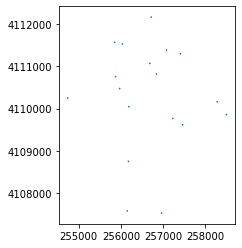

In [15]:
sjer_plots_poly.plot()

# Export the new polygon layer as a shapefile 
1. path where you want to export the data
2. actual function to export the data

In [16]:
plot_buffer_path = os.path.join(
    "data", "spatial-vector-lidar", "outputs", "sjer_plot_buffer.shp")
# Export the data!
sjer_plots_poly.to_file(plot_buffer_path)

In [27]:
# Use zonal stats to calculate mean and max pixel values

# Run zonal stats 
sjer_lidar_tree_heights = rs.zonal_stats(plot_buffer_path,
                                        sjer_lidar_chm,
                                        affine=sjer_lidar_chm_meta["transform"], # this provides CRS information
                                        geojson_out=True, # output spatial information for plotting later
                                        copy_properties=True, # 
                                        #nodata=0,  # leah will look into whether we can skip the step above of assigning 0 to np.nan
                                        stats=["mean", "max"])
#sjer_lidar_tree_heights

In [30]:
# turn it into a geodataframe
sjer_lidar_tree_heights_df = gpd.GeoDataFrame.from_features(sjer_lidar_tree_heights)
sjer_lidar_tree_heights_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,max,mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176


In [40]:
# Rename requires a dictionary that maps the existing column names to new names
rename_dict_lidar = {"mean":"lidar_mean",
                    "max":"lidar_max"} 
sjer_lidar_tree_heights_df.rename(columns = rename_dict_lidar, inplace=True)
sjer_lidar_tree_heights_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176


# Import the insitu (human collected)
field techs out measuring trees laser finders...


In [46]:
# Import the csv of human measured (insitu) tree height data
path_insitu = os.path.join(sjer_data_path, "2013", "insitu", "veg_structure","D17_2013_SJER_vegStr.csv")
sjer_insitu_all = pd.read_csv(path_insitu)

sjer_insitu_all.head(3)

,siteid,sitename,plotid,easting,northing,taxonid,scientificname,indvidual_id,pointid,individualdistance,...,canopyform,livingcanopy,inplotcanopy,materialsampleid,dbhqf,stemmapqf,plant_group,common_name,aop_plot,unique_id
0,SJER,San Joaquin,SJER128,257085.7,4111381.5,PISA2,Pinus sabiniana,1485,center,9.7,...,NaN,100,100,NaN,0,0,NaN,NaN,NaN,NaN
1,SJER,San Joaquin,SJER2796,256047.7,4111548.5,ARVI4,Arctostaphylos viscida,1622,NE,5.8,...,Hemisphere,70,100,f095,0,0,NaN,NaN,NaN,NaN
2,SJER,San Joaquin,SJER272,256722.9,4112170.2,ARVI4,Arctostaphylos viscida,1427,center,6.0,...,Hemisphere,35,100,NaN,0,0,NaN,NaN,NaN,NaN


In [53]:
# there are a lot of columns
sjer_insitu_all.columns
# subset the data frame to only include the columns that we want to use
sjer_insitu = sjer_insitu_all[["plotid","stemheight"]]

sjer_insitu.head(3)


,plotid,stemheight
0,SJER128,18.2
1,SJER2796,3.3
2,SJER272,1.7


In [58]:
# Summarize the mean and max insitu measured height data for each plot
# groupby groupd the data by plot id, agg is the summary functions run on the data (mean and max)
# column that you want to use to summarize - tree height data
insitu_stem_ht = sjer_insitu.groupby(
    "plotid").agg(["mean", "max"])["stemheight"]
insitu_stem_ht.rename(columns = {"mean":"insitu_mean",
                      "max":"insitu_max"}, inplace=True)
insitu_stem_ht.head()

,insitu_mean,insitu_max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [63]:
sjer_final_height = sjer_lidar_tree_heights_df.merge(insitu_stem_ht,
                                                    left_on="Plot_ID",
                                                    right_on="plotid")
sjer_final_height.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,8.218750,16.0
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347,6.512500,11.0
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176,7.600000,8.8
